# Imports

In [ ]:
import keras
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Variable Names + Positions within CSV

In [ ]:
variablesIndex = [5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
variablesName = ["T", "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "CO", "CO2", "CH2O",
                 "HO2CHO", "O2CHO", "CH3O2H", "CH3O2", "CH4", "CH3", "C2H5", "C2H4", "C2H3",
                 "CH3CHO", "C2H5OH", "O2C2H4OH"]

# Read Data from Single Timestep (2.200E-03)

In [ ]:
clean_data = []
for j in range(len(variablesIndex)):
  start = time.time()
  clean_data.append(pd.read_csv(
    'drive/My Drive/DNS Autoencoders/plane-xy-0.50.2.200E-03.csv',
    header=None,
    index_col=None,
    skiprows=lambda row: row < (31360 * (variablesIndex[j] - 1) + 37),
    nrows=31360,
    engine='python',
    dtype='float32'
  ))
  stop = time.time()
  print(f'Variable {variablesName[j]} Read in {round(stop-start, 2)}s')

Variable T Read in 0.52s
Variable H Read in 0.57s
Variable H2 Read in 0.61s
Variable O Read in 0.75s
Variable O2 Read in 0.73s
Variable OH Read in 0.77s
Variable H2O Read in 0.92s
Variable HO2 Read in 0.92s
Variable H2O2 Read in 0.93s
Variable CO Read in 1.08s
Variable CO2 Read in 1.04s
Variable CH2O Read in 1.11s
Variable HO2CHO Read in 1.26s
Variable O2CHO Read in 1.2s
Variable CH3O2H Read in 1.26s
Variable CH3O2 Read in 1.41s
Variable CH4 Read in 1.36s
Variable CH3 Read in 1.43s
Variable C2H5 Read in 1.54s
Variable C2H4 Read in 1.54s
Variable C2H3 Read in 1.58s
Variable CH3CHO Read in 1.74s
Variable C2H5OH Read in 1.75s
Variable O2C2H4OH Read in 1.75s


# Scale Data to (0, 1) Feature Range

In [ ]:
mins, maxs = [], []
for j in range(len(variablesIndex)):
    mins.append(clean_data[j].to_numpy().min())
    maxs.append(clean_data[j].to_numpy().max())
    clean_data[j] = (clean_data[j] - np.full_like(clean_data[j], mins[j])) / (np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j]))

# Reshape to 560x560 image

In [ ]:
for j in range(len(variablesIndex)):
    clean_data[j] = np.array(clean_data[j]).reshape((560, 560))

# Make Copy + Add 10% Gaussian Noise

In [ ]:
noisy_data = list(clean_data)
for j in range(len(variablesIndex)):
    noisy_data[j] = noisy_data[j] + 0.10 * np.random.normal(loc=0.0, scale=1.0, size=noisy_data[j].shape)

# Stack Images of Temp. + Species for Training

In [ ]:
noisy_stacked_train = np.concatenate(noisy_data).reshape((1, len(variablesIndex)*560, 560, 1))

# Build Autoencoder

In [ ]:
input_img = keras.layers.Input(shape=(len(variablesIndex)*560, 560, 1))
x = keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(input_img)
x = keras.layers.Conv2D(16, 3, strides=1, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)

In [ ]:
autoencoder = keras.Model(input_img, x)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13440, 560, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6720, 280, 64)     640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6720, 280, 16)     9232      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13440, 560, 64)    9280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13440, 560, 1)     65        
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


# Compile + Train + Save Autoencoder

In [ ]:
autoencoder.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.BinaryCrossentropy(name='binary_crossentropy'), keras.metrics.MeanAbsoluteError(name='mae'), keras.metrics.RootMeanSquaredError(name='rmse')])
hist = autoencoder.fit(noisy_stacked_train, noisy_stacked_train, epochs=200, callbacks=[keras.callbacks.EarlyStopping(patience=3, monitor='loss')])

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 0.1796 - binary_crossentropy: 0.6937 - mae: 0.3883 - rmse: 0.4237
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1784 - binary_crossentropy: 0.6913 - mae: 0.3870 - rmse: 0.4223
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1772 - binary_crossentropy: 0.6890 - mae: 0.3857 - rmse: 0.4210
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1760 - binary_crossentropy: 0.6866 - mae: 0.3844 - rmse: 0.4196
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1748 - binary_crossentropy: 0.6842 - mae: 0.3831 - rmse: 0.4181
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1734 - binary_crossentropy: 0.6814 - mae: 0.3816 - rmse: 0.4164
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1719 - binary_crossentropy: 0.6783 - mae: 0.3799 - rmse: 0.4146
Epoch 8/200
1/1 [========================

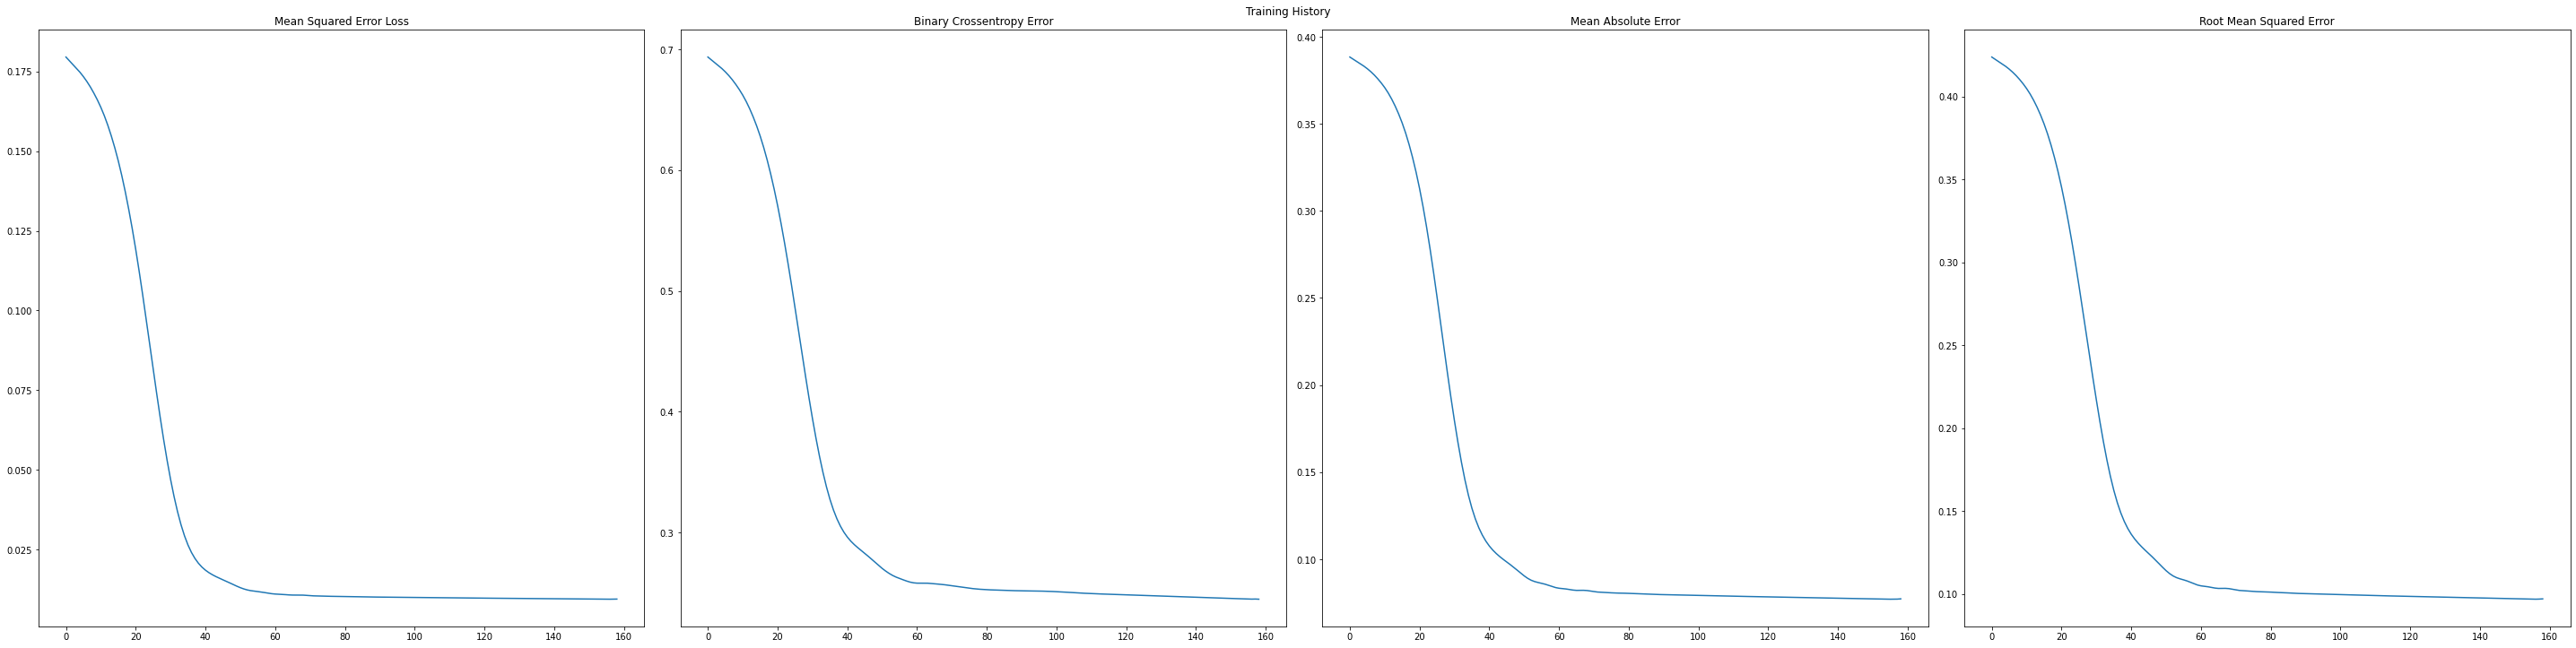

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Training History', y=1.0)

ax1.set_title('Mean Squared Error Loss')
ax1.plot(hist.history['loss'])

ax2.set_title('Binary Crossentropy Error')
ax2.plot(hist.history['binary_crossentropy'])

ax3.set_title('Mean Absolute Error')
ax3.plot(hist.history['mae'])

ax4.set_title('Root Mean Squared Error')
ax4.plot(hist.history['rmse'])

plt.tight_layout()
plt.show()

In [ ]:
autoencoder.save('drive/My Drive/DNS Autoencoders/ConvAutoencoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/DNS Autoencoders/ConvAutoencoder/assets


# Predict on Training Set

In [ ]:
predicted = np.split(autoencoder.predict(noisy_stacked_train).reshape((len(variablesIndex)*560, 560)), len(variablesIndex))

# Reverse Scale Data

In [ ]:
for j in range(len(variablesIndex)):
  predicted[j] = predicted[j]*(np.full_like(predicted[j], maxs[j]) - np.full_like(predicted[j], mins[j])) + np.full_like(predicted[j], mins[j])
  clean_data[j] =clean_data[j]*(np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j])) + np.full_like(clean_data[j], mins[j])
  noisy_data[j] =noisy_data[j]*(np.full_like(noisy_data[j], maxs[j]) - np.full_like(noisy_data[j], mins[j])) + np.full_like(noisy_data[j], mins[j])

# Visualize Predictions on Training Set

In [ ]:
for j in range(len(variablesIndex)):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
  fig.suptitle(f'Variable = {variablesName[j]}', y=0.8)
  
  ax1.set_title("Clean")
  ax1.imshow(clean_data[j])
  
  ax2.set_title("Noisy")
  ax2.imshow(noisy_data[j])

  ax3.set_title("Predicted")
  ax3.imshow(predicted[j])

  plt.savefig(f'drive/My Drive/DNS Autoencoders/2.200E-03 Results/{variablesName[j]}.tiff')
  plt.tight_layout()
  plt.show()

# Compute correlations + Plot Differences

Correlation coefficient for T: 0.9718078248534884


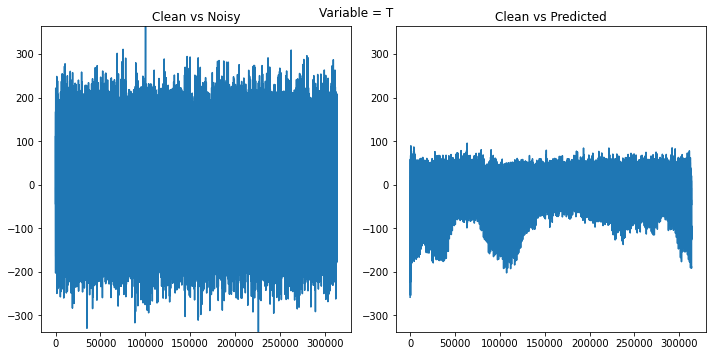

Correlation coefficient for H: 0.9888584127849498


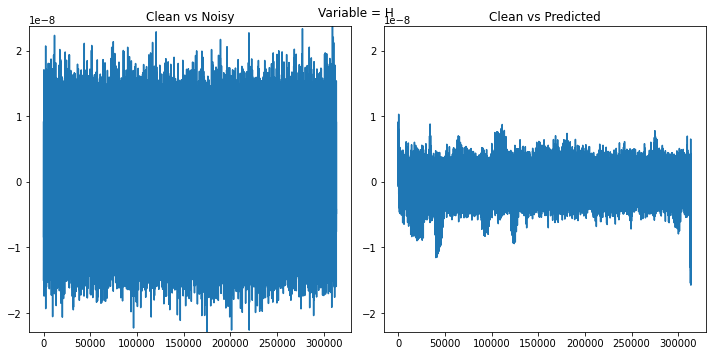

Correlation coefficient for H2: 0.9856778506838572


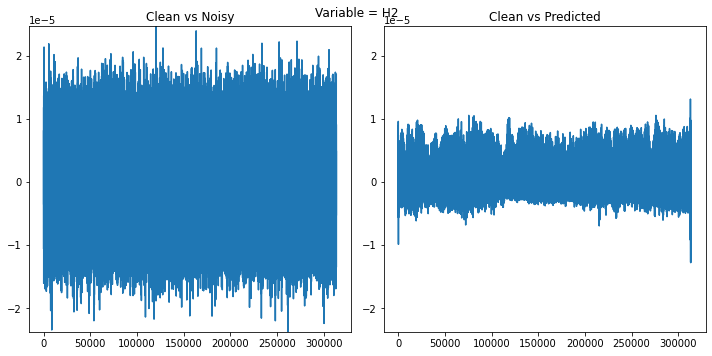

Correlation coefficient for O: 0.991708387800632


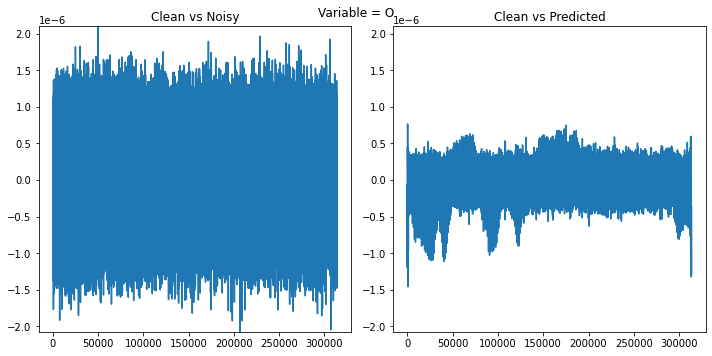

Correlation coefficient for O2: 0.973864579682195


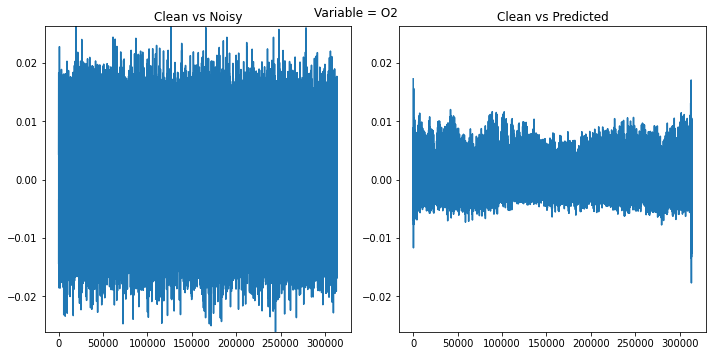

Correlation coefficient for OH: 0.9949930240635539


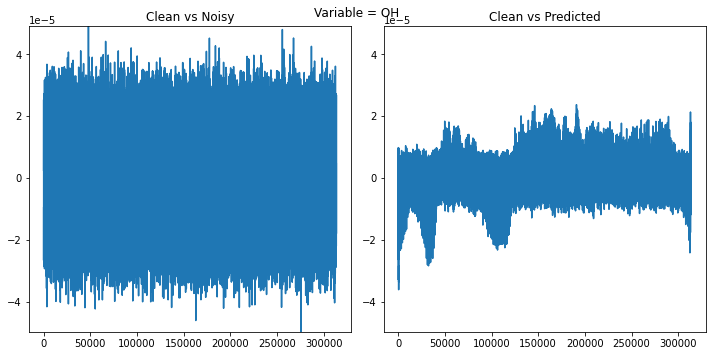

Correlation coefficient for H2O: 0.8918713279646807


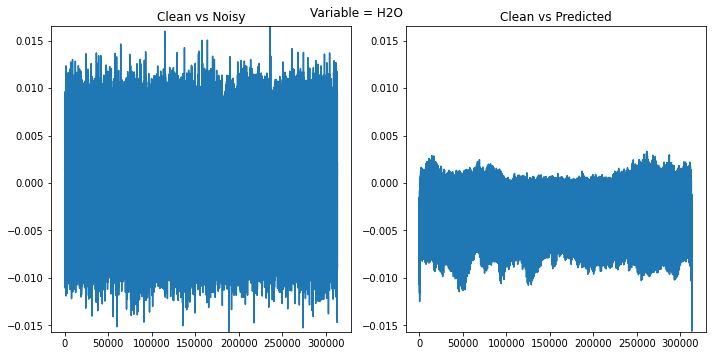

Correlation coefficient for HO2: 0.9705388607400538


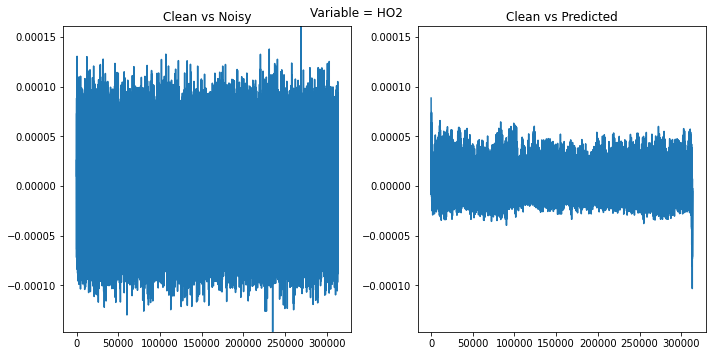

Correlation coefficient for H2O2: 0.9706678178194895


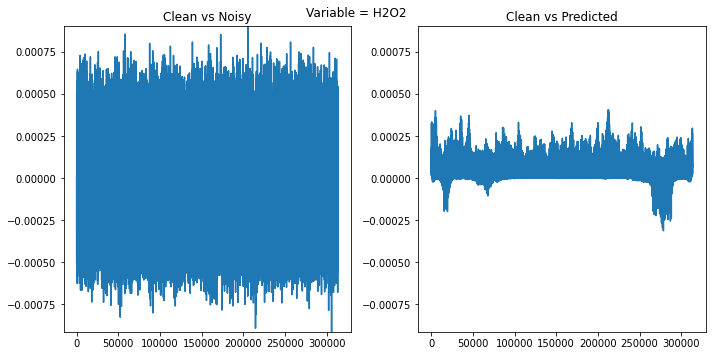

Correlation coefficient for CO: 0.9942432118450395


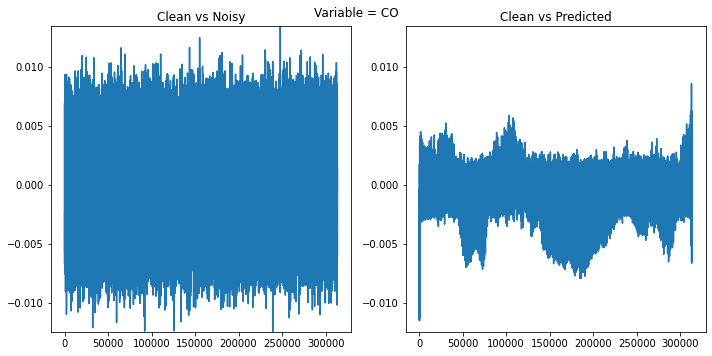

Correlation coefficient for CO2: 0.9903725030289675


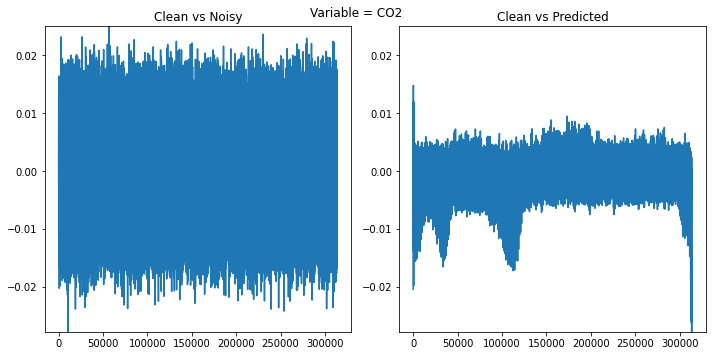

Correlation coefficient for CH2O: 0.9783897621261864


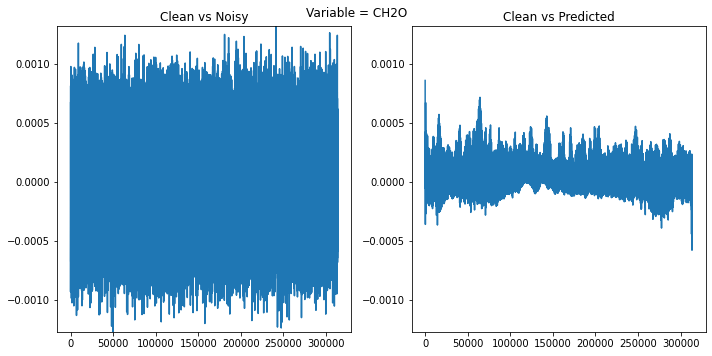

Correlation coefficient for HO2CHO: 0.9680727506200889


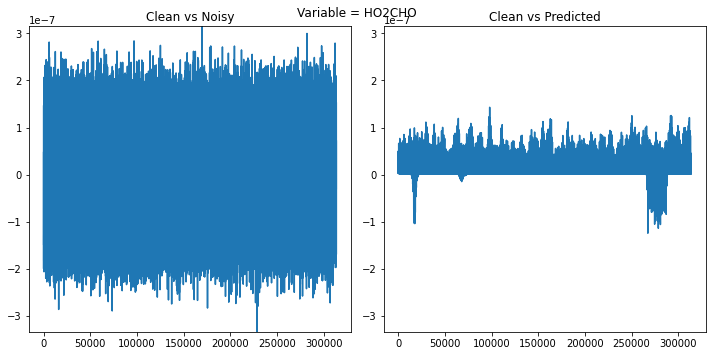

Correlation coefficient for O2CHO: 0.9731981115327061


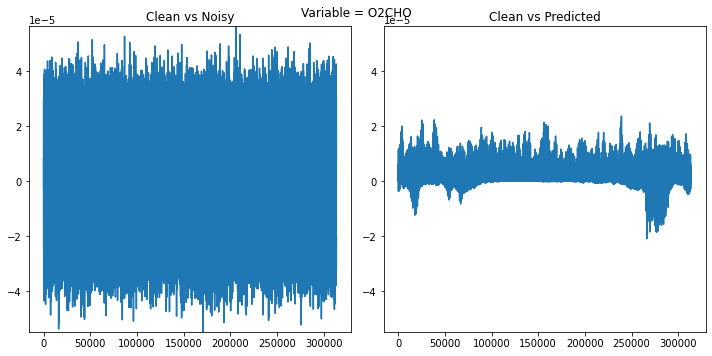

Correlation coefficient for CH3O2H: 0.9677323149752712


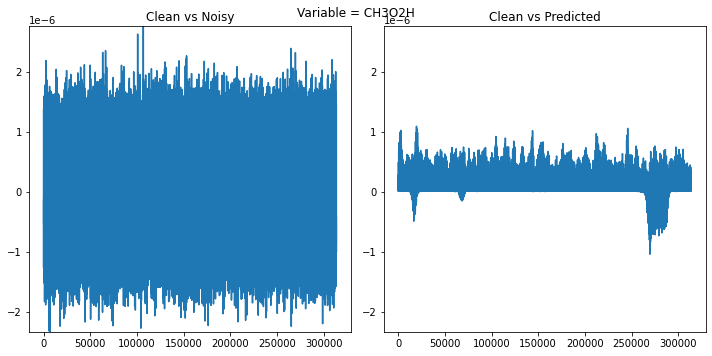

Correlation coefficient for CH3O2: 0.9708631343068329


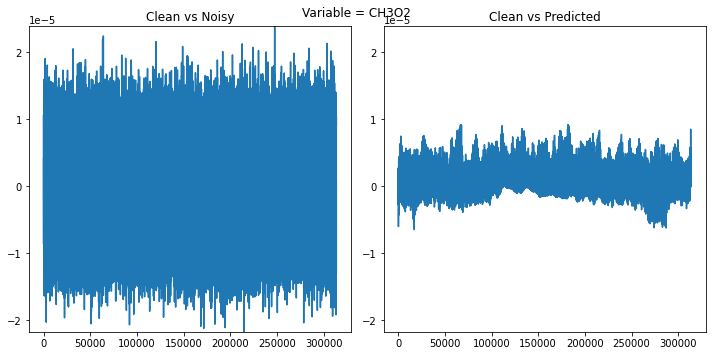

Correlation coefficient for CH4: 0.9953978043502613


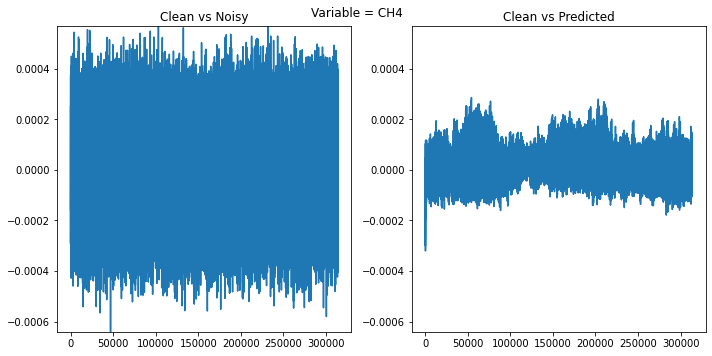

Correlation coefficient for CH3: 0.995979399926213


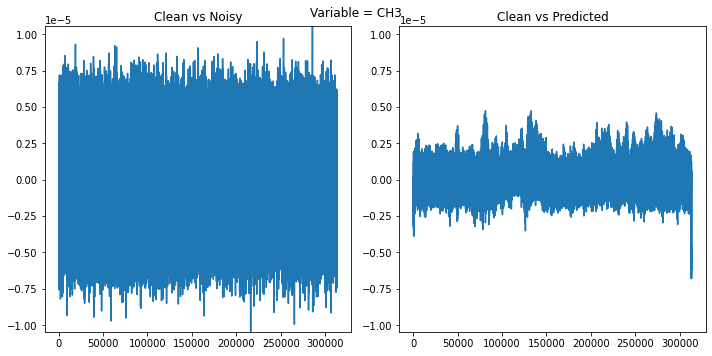

Correlation coefficient for C2H5: 0.983915767921855


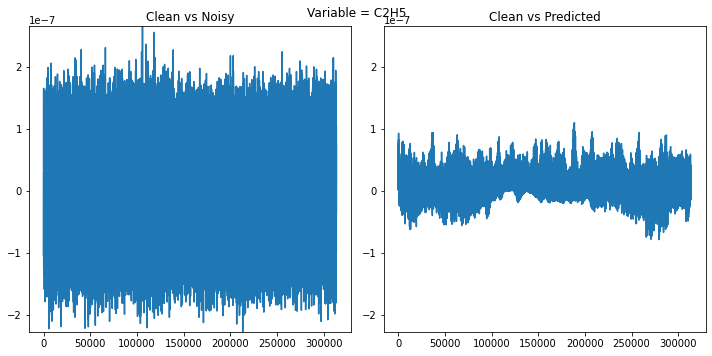

Correlation coefficient for C2H4: 0.992345927879183


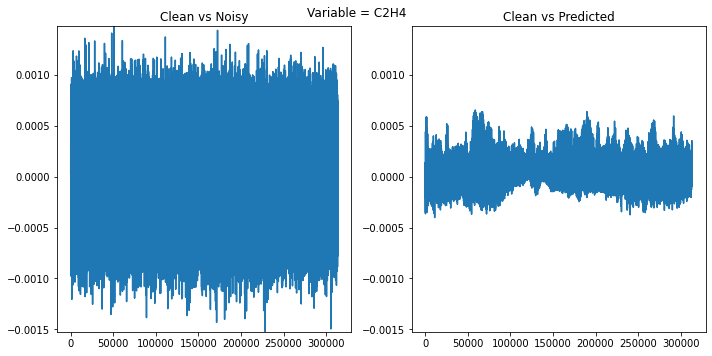

Correlation coefficient for C2H3: 0.9935907542963817


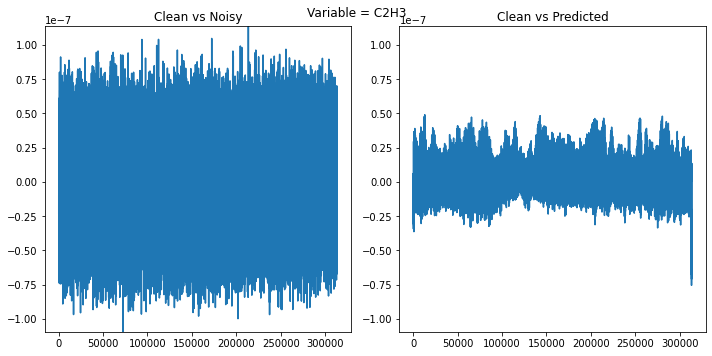

Correlation coefficient for CH3CHO: 0.9836604117426585


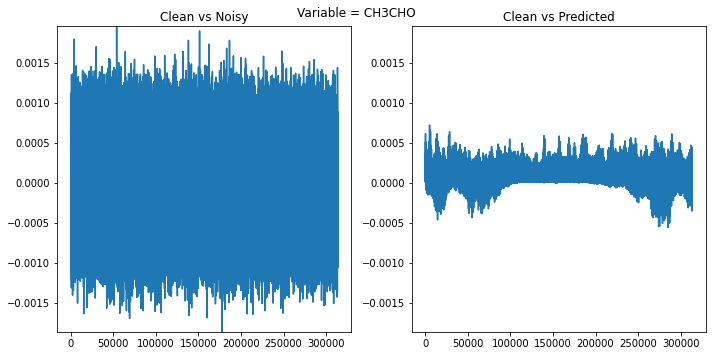

Correlation coefficient for C2H5OH: 0.969585371156123


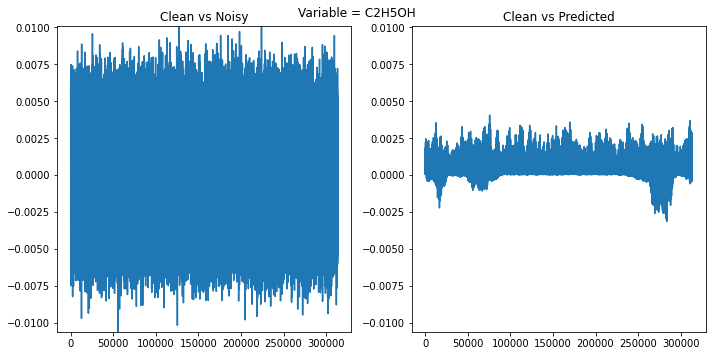

Correlation coefficient for O2C2H4OH: 0.9711440784609844


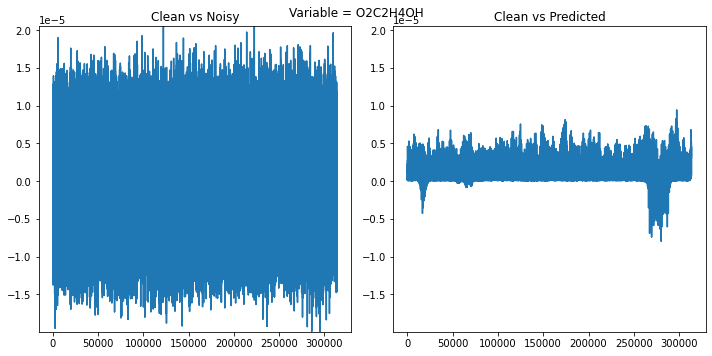

In [ ]:
for j in range(len(variablesIndex)):
  r = np.corrcoef(clean_data[j].flat, predicted[j].flat)[0, 1]
  print(f'Correlation coefficient for {variablesName[j]}: {r}')

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  fig.suptitle(f'Variable = {variablesName[j]}')

  clean_noisy_diff = np.subtract(noisy_data[j].flat, clean_data[j].flat)
  ax1.set_title('Clean vs Noisy')
  ax1.set_ylim([clean_noisy_diff.min(), clean_noisy_diff.max()])
  ax1.plot(clean_noisy_diff)

  clean_pred_diff = np.subtract(predicted[j].flat,clean_data[j].flat)
  ax2.set_title('Clean vs Predicted')
  ax2.set_ylim([clean_noisy_diff.min(), clean_noisy_diff.max()])
  ax2.plot(clean_pred_diff)

  plt.tight_layout()
  plt.show()

# Read + Predict + Visualize different timestep (2.200E-03)

In [ ]:
clean_data = []
for j in range(len(variablesIndex)):
  start = time.time()
  clean_data.append(pd.read_csv(
    'drive/My Drive/DNS Autoencoders/plane-xy-0.50.1.935E-03.csv',
    header=None,
    index_col=None,
    skiprows=lambda row: row < (31360 * (variablesIndex[j] - 1) + 37),
    nrows=31360,
    engine='python',
    dtype='float32'
  ))
  stop = time.time()
  print(f'Variable {variablesName[j]} Read in {round(stop-start, 2)}s')
  mins, maxs = [], []

Variable T Read in 6.66s
Variable H Read in 0.58s
Variable H2 Read in 2.63s
Variable O Read in 1.11s
Variable O2 Read in 1.44s
Variable OH Read in 3.17s
Variable H2O Read in 1.45s
Variable HO2 Read in 1.1s
Variable H2O2 Read in 2.21s
Variable CO Read in 1.03s
Variable CO2 Read in 1.28s
Variable CH2O Read in 1.32s
Variable HO2CHO Read in 3.25s
Variable O2CHO Read in 1.22s
Variable CH3O2H Read in 1.37s
Variable CH3O2 Read in 1.34s
Variable CH4 Read in 1.44s
Variable CH3 Read in 1.56s
Variable C2H5 Read in 1.55s
Variable C2H4 Read in 1.56s
Variable C2H3 Read in 1.7s
Variable CH3CHO Read in 1.67s
Variable C2H5OH Read in 1.73s
Variable O2C2H4OH Read in 1.89s


In [ ]:
for j in range(len(variablesIndex)):
    mins.append(clean_data[j].to_numpy().min())
    maxs.append(clean_data[j].to_numpy().max())
    clean_data[j] = (clean_data[j] - np.full_like(clean_data[j], mins[j])) / (np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j]))

for j in range(len(variablesIndex)):
    clean_data[j] = np.array(clean_data[j]).reshape((560, 560))
noisy_data = list(clean_data)

for j in range(len(variablesIndex)):
    noisy_data[j] = noisy_data[j] + 0.10 * np.random.normal(loc=0.0, scale=1.0, size=noisy_data[j].shape)

noisy_stacked_train = np.concatenate(noisy_data).reshape((1, len(variablesIndex)*560, 560, 1))

In [ ]:
predicted = np.split(autoencoder.predict(noisy_stacked_train).reshape((len(variablesIndex)*560, 560)), len(variablesIndex))

for j in range(len(variablesIndex)):
  predicted[j] = predicted[j]*(np.full_like(predicted[j], maxs[j]) - np.full_like(predicted[j], mins[j])) + np.full_like(predicted[j], mins[j])
  clean_data[j] =clean_data[j]*(np.full_like(clean_data[j], maxs[j]) - np.full_like(clean_data[j], mins[j])) + np.full_like(clean_data[j], mins[j])
  noisy_data[j] =noisy_data[j]*(np.full_like(noisy_data[j], maxs[j]) - np.full_like(noisy_data[j], mins[j])) + np.full_like(noisy_data[j], mins[j])

In [ ]:
for j in range(len(variablesIndex)):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
  fig.suptitle(f'Variable = {variablesName[j]}', y=0.8)
  
  ax1.set_title("Clean")
  ax1.imshow(clean_data[j])
  
  ax2.set_title("Noisy")
  ax2.imshow(noisy_data[j])

  ax3.set_title("Predicted")
  ax3.imshow(predicted[j])

  plt.savefig(f'drive/My Drive/DNS Autoencoders/1.935E-03 Results/{variablesName[j]}.tiff')
  plt.tight_layout()
  plt.show()

Correlation coefficient for T: 0.9894171404089229
Correlation coefficient for H: 0.9794970935351904
Correlation coefficient for H2: 0.9916557465538395
Correlation coefficient for O: 0.98661909236314
Correlation coefficient for O2: 0.9872099602541549
Correlation coefficient for OH: 0.9936558493460589
Correlation coefficient for H2O: 0.9933348785766358
Correlation coefficient for HO2: 0.9903507975511098
Correlation coefficient for H2O2: 0.996840549265812
Correlation coefficient for CO: 0.9951343859868893
Correlation coefficient for CO2: 0.9922760621615732
Correlation coefficient for CH2O: 0.9947550738600908
Correlation coefficient for HO2CHO: 0.9966291026864379
Correlation coefficient for O2CHO: 0.996437424003967
Correlation coefficient for CH3O2H: 0.9973635232914372
Correlation coefficient for CH3O2: 0.9955762336608797
Correlation coefficient for CH4: 0.9949160252129166
Correlation coefficient for CH3: 0.9859468037664088
Correlation coefficient for C2H5: 0.9933989161705316
Correlation c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

Correlation coefficient for CH3CHO: 0.9959901792624741
Correlation coefficient for C2H5OH: 0.9963727628026633
Correlation coefficient for O2C2H4OH: 0.9976838854284975


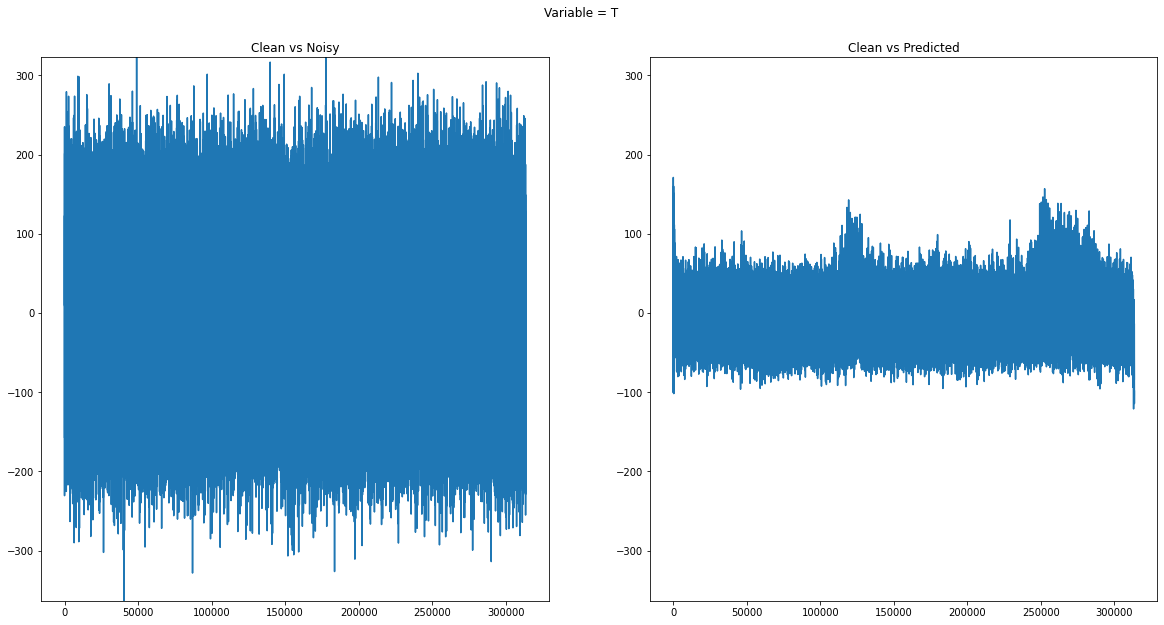

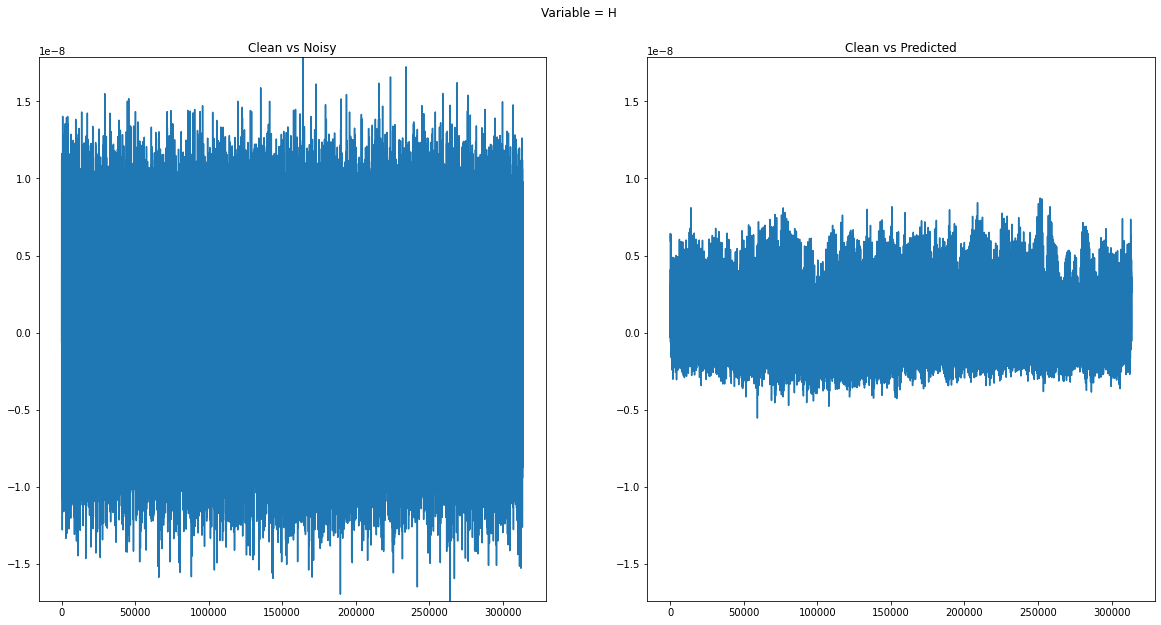

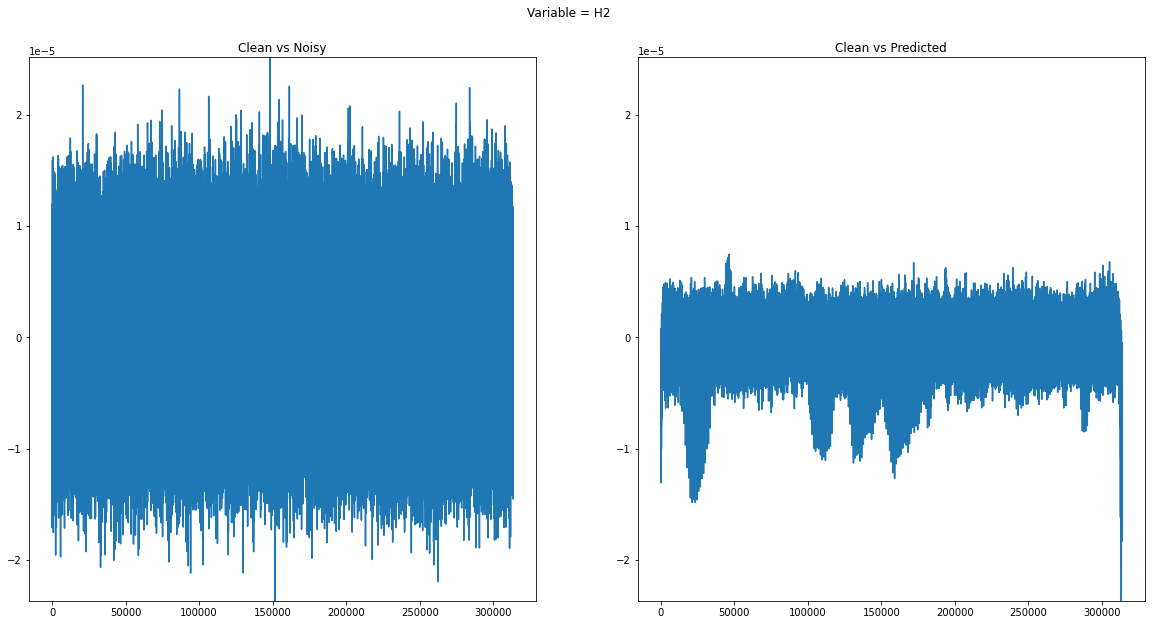

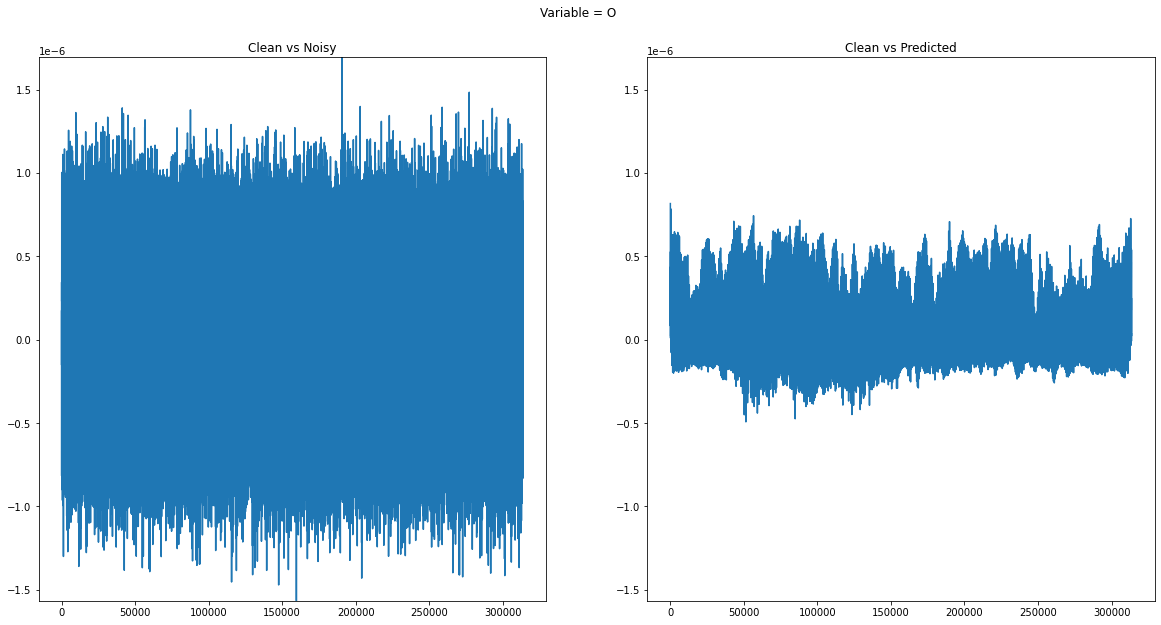

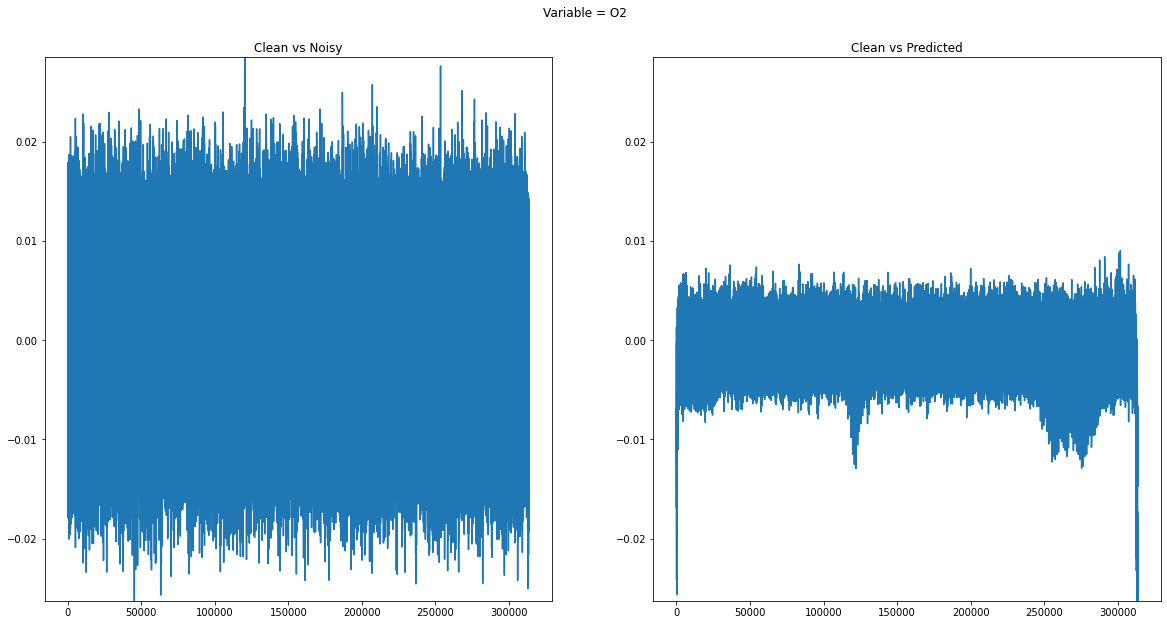

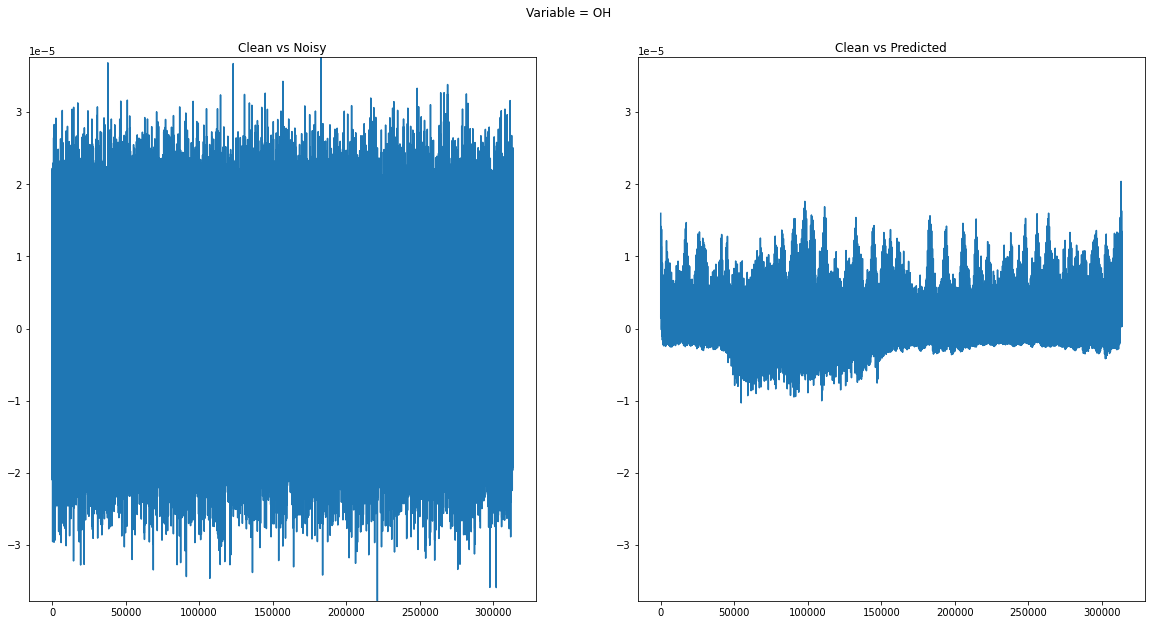

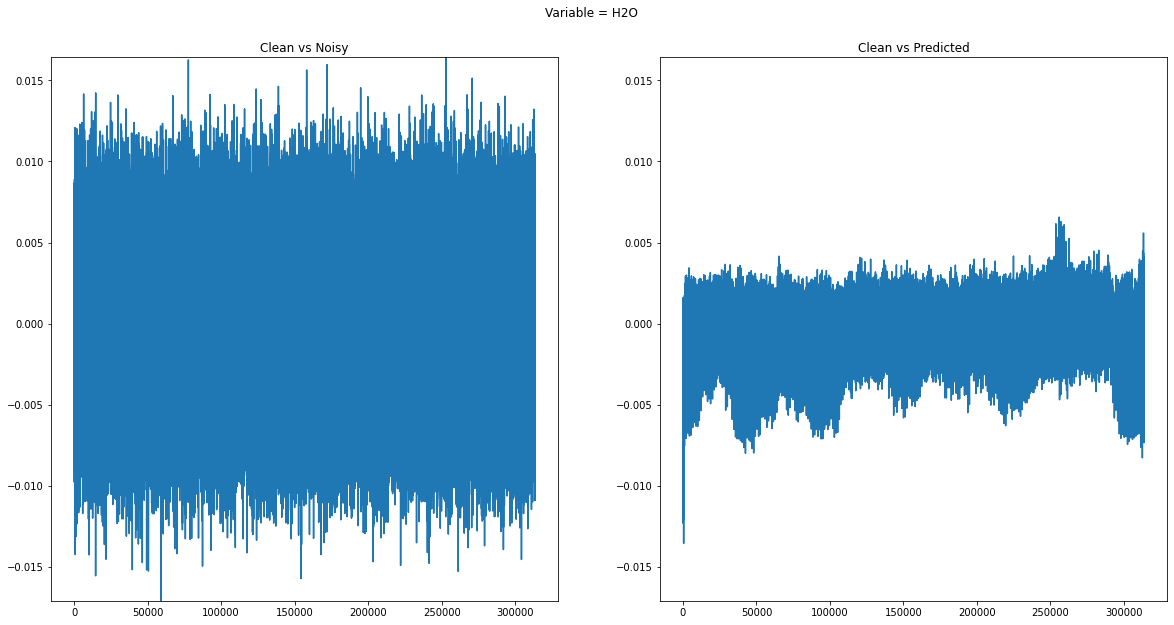

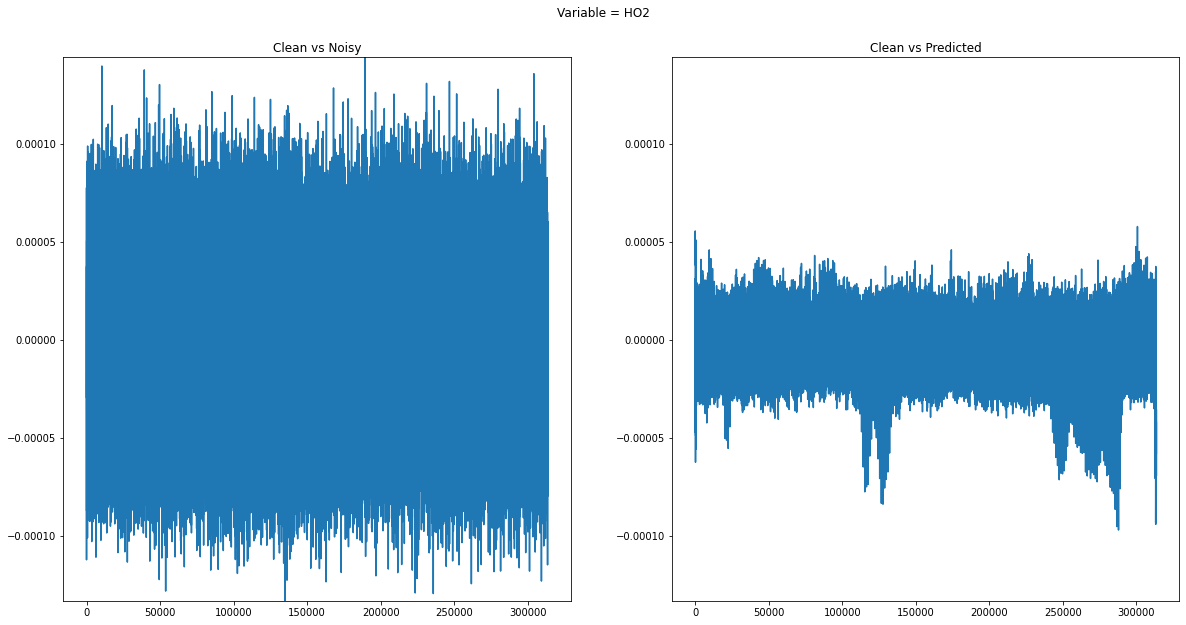

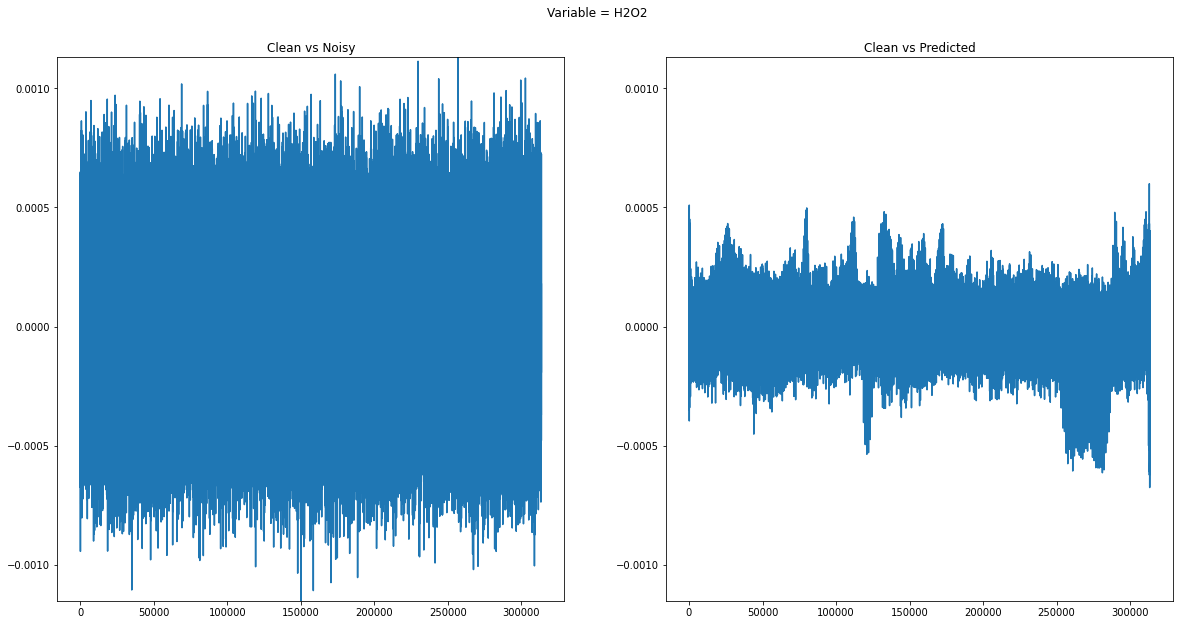

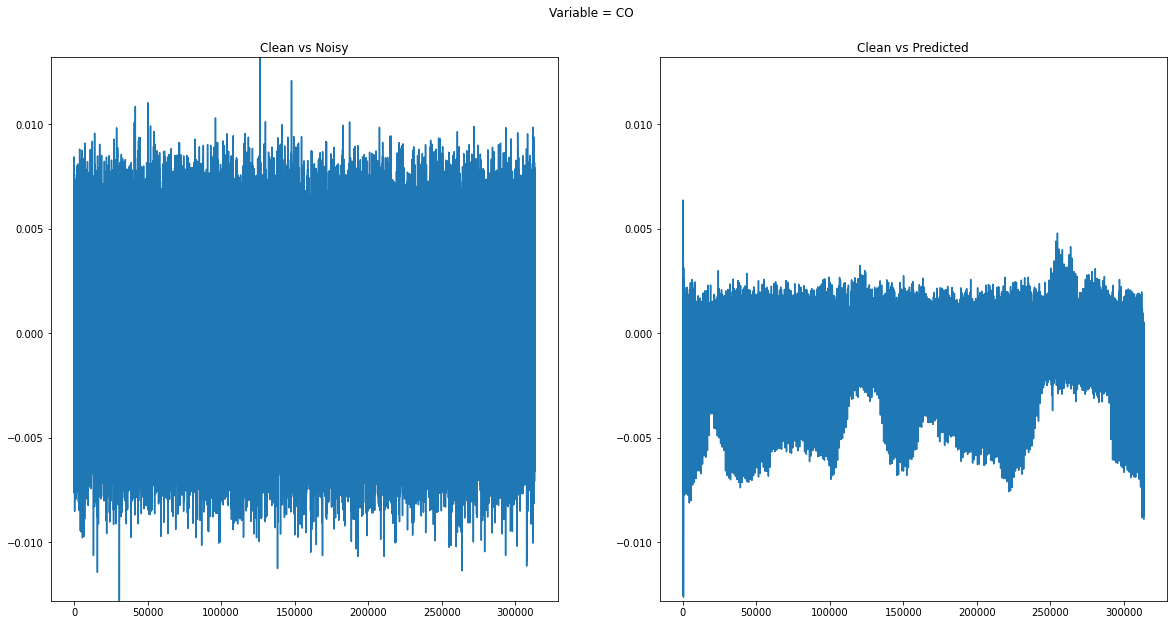

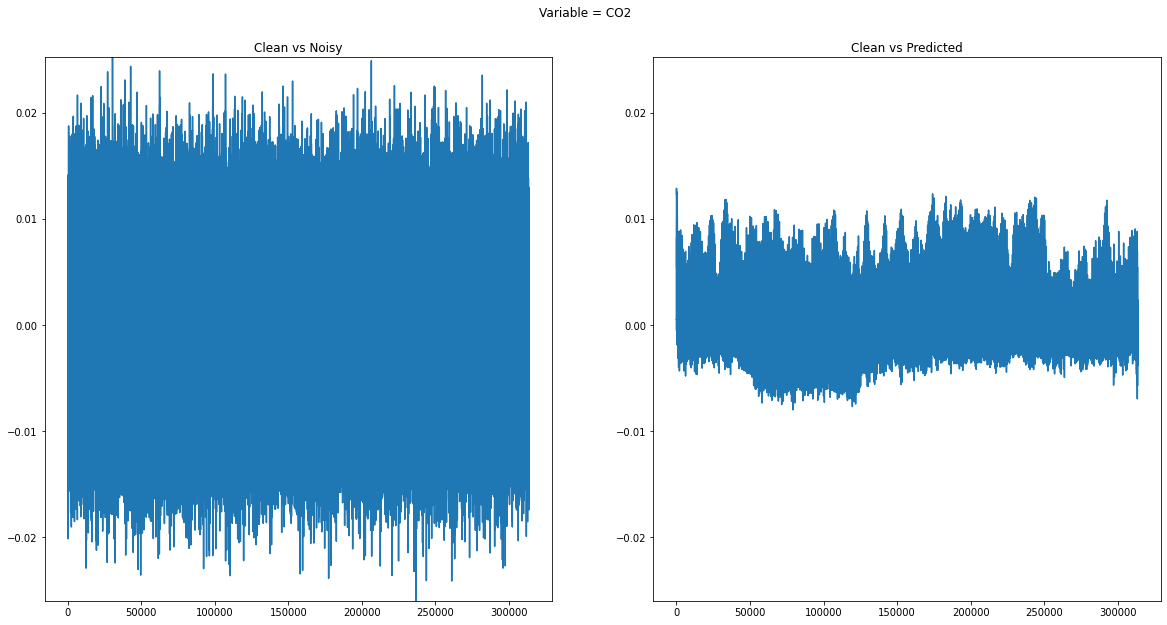

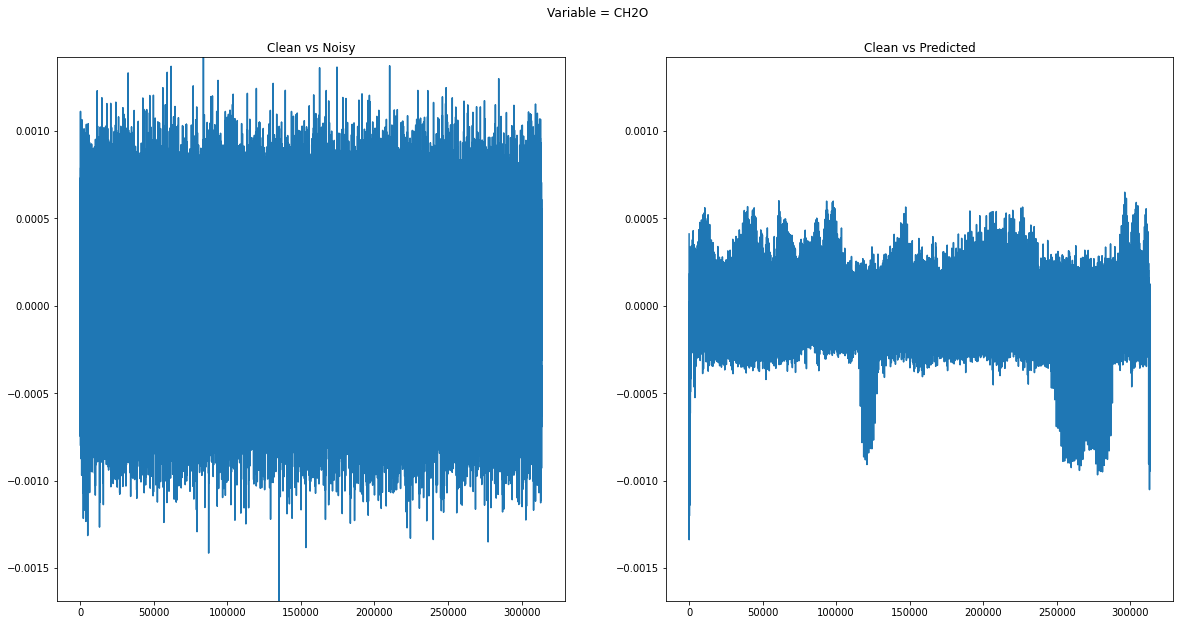

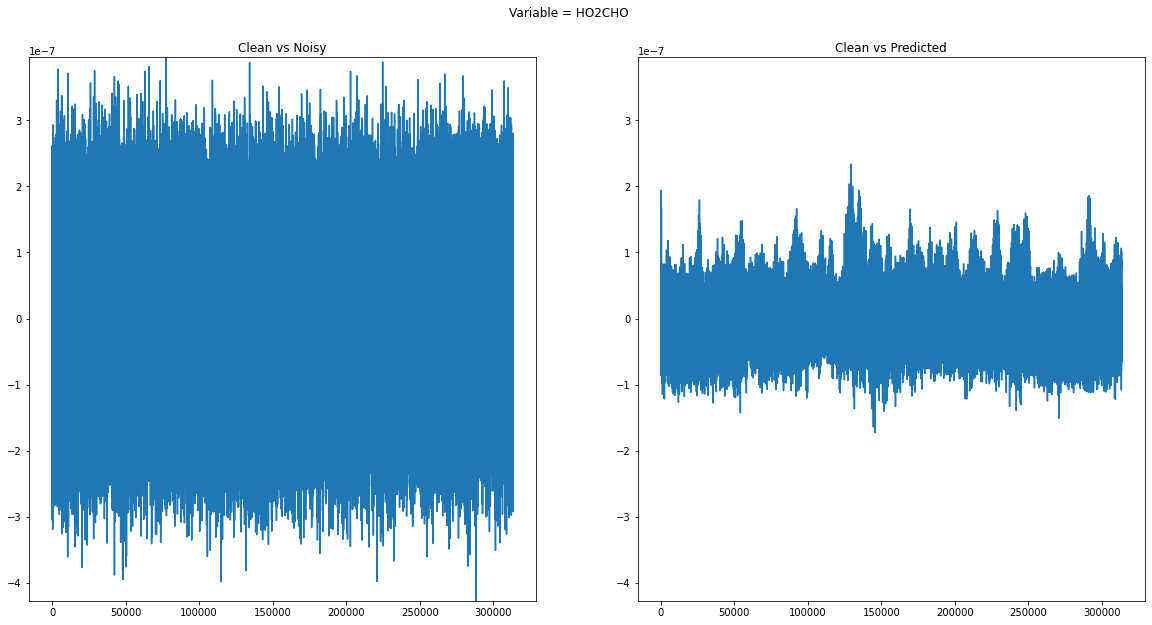

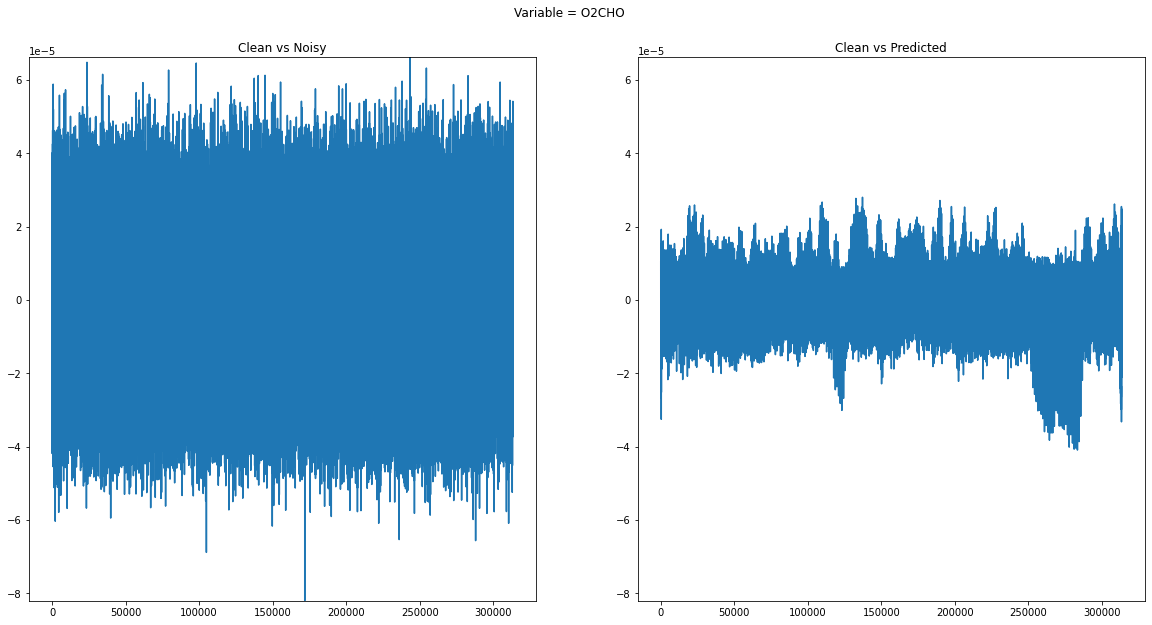

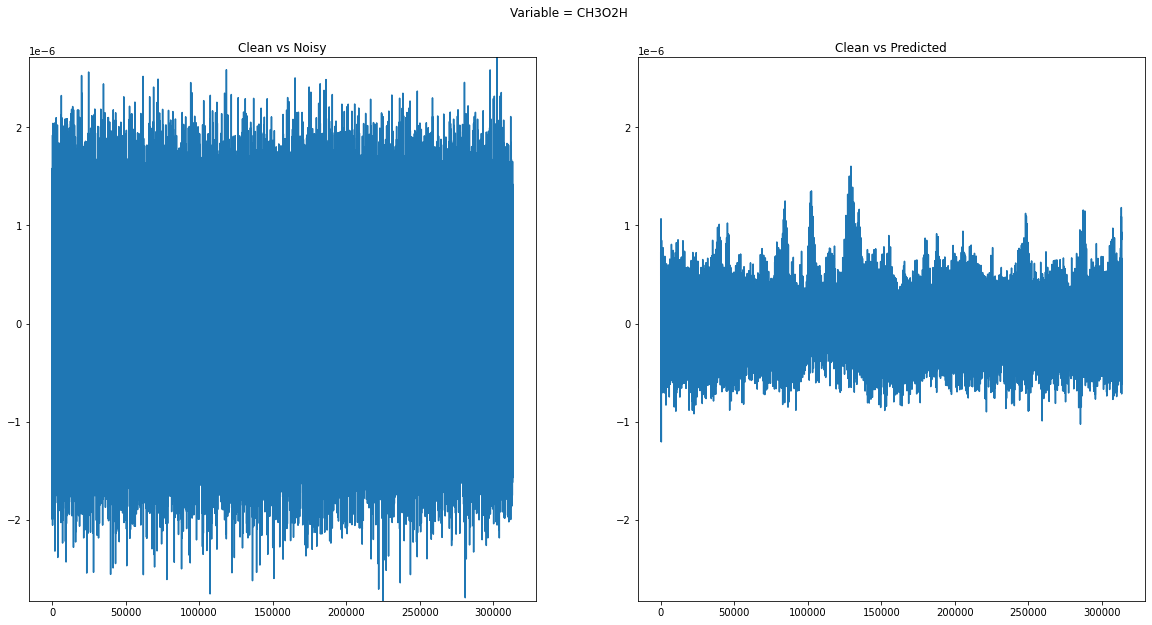

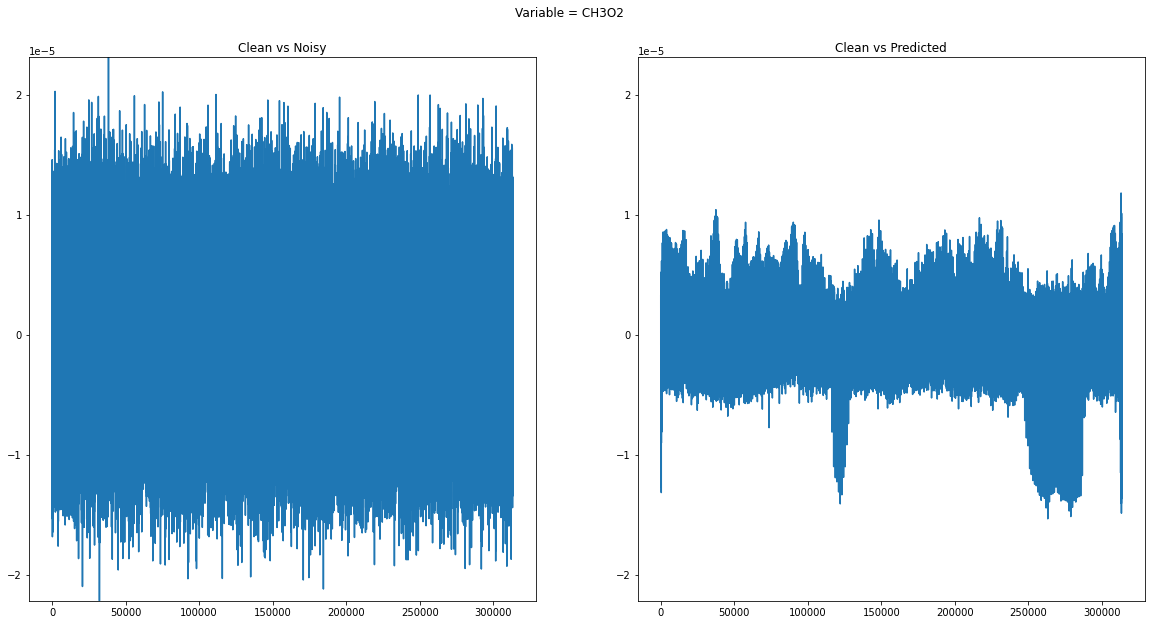

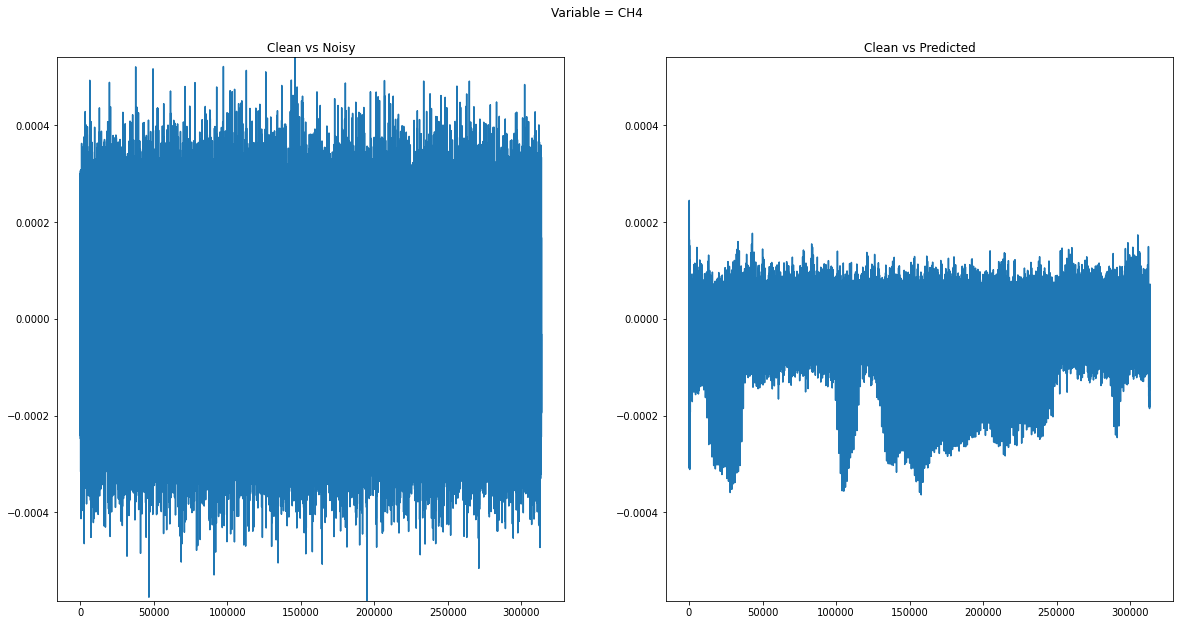

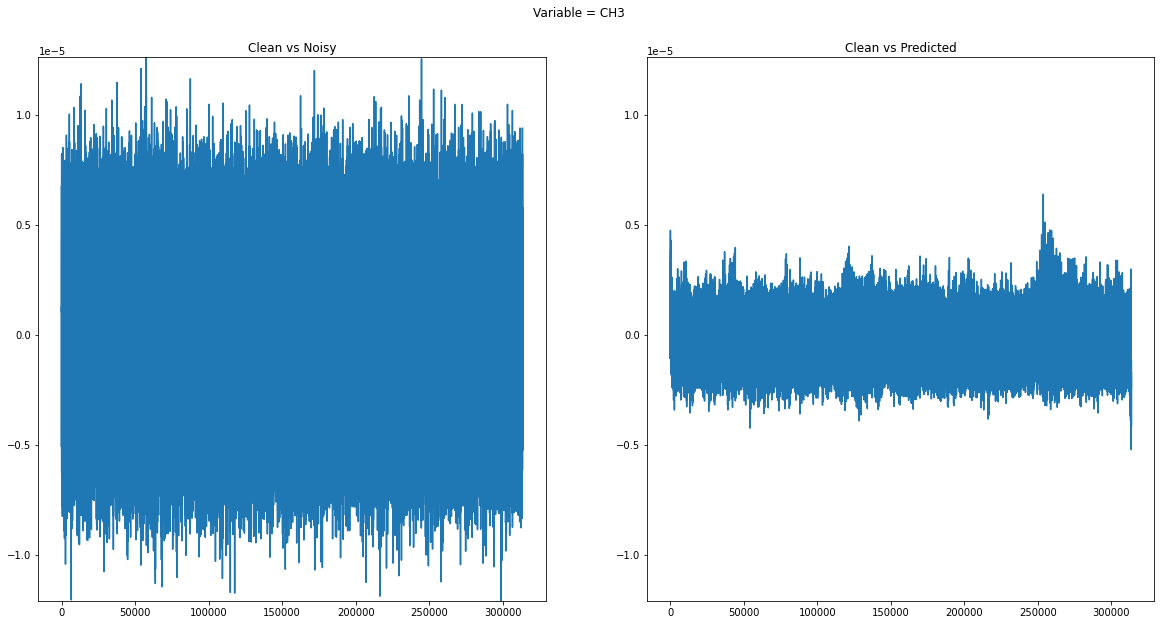

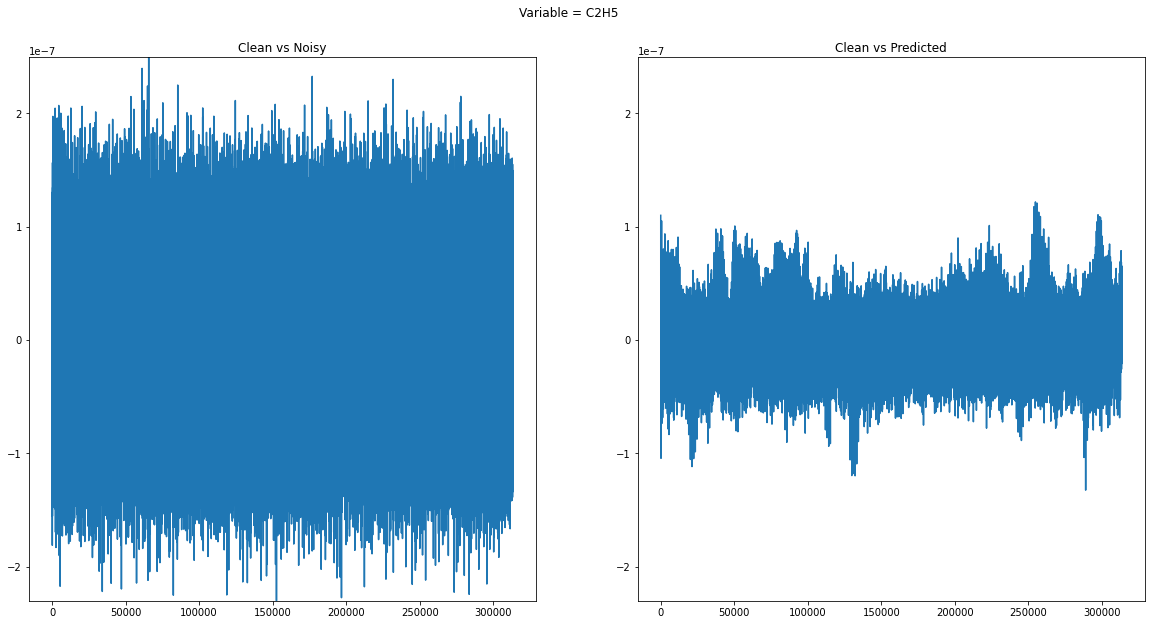

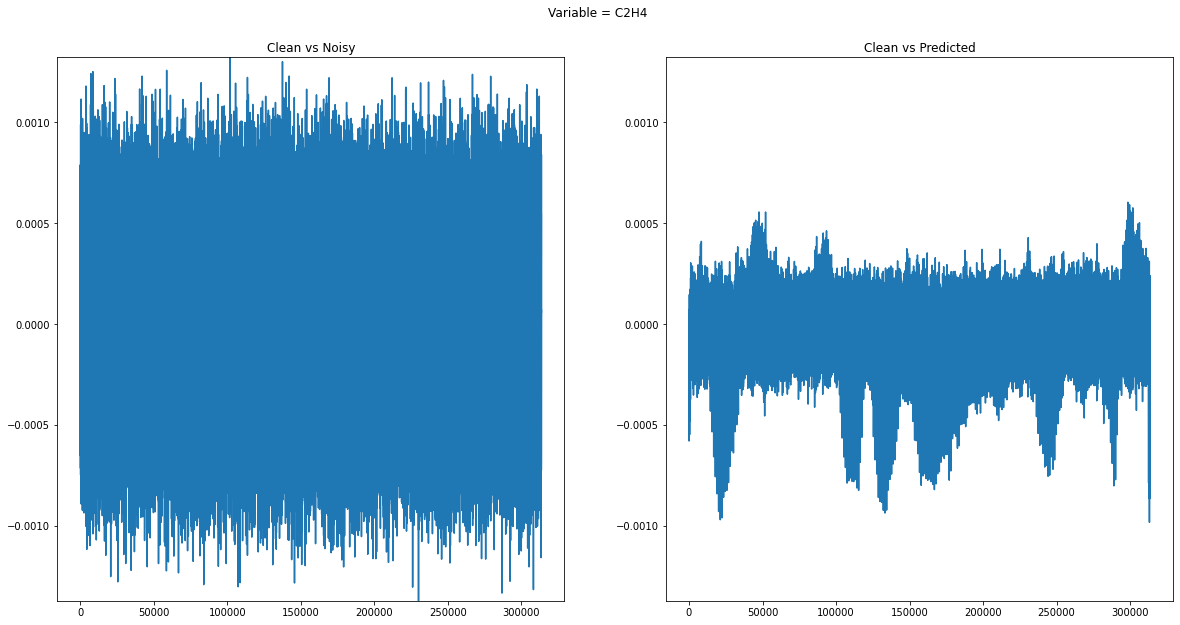

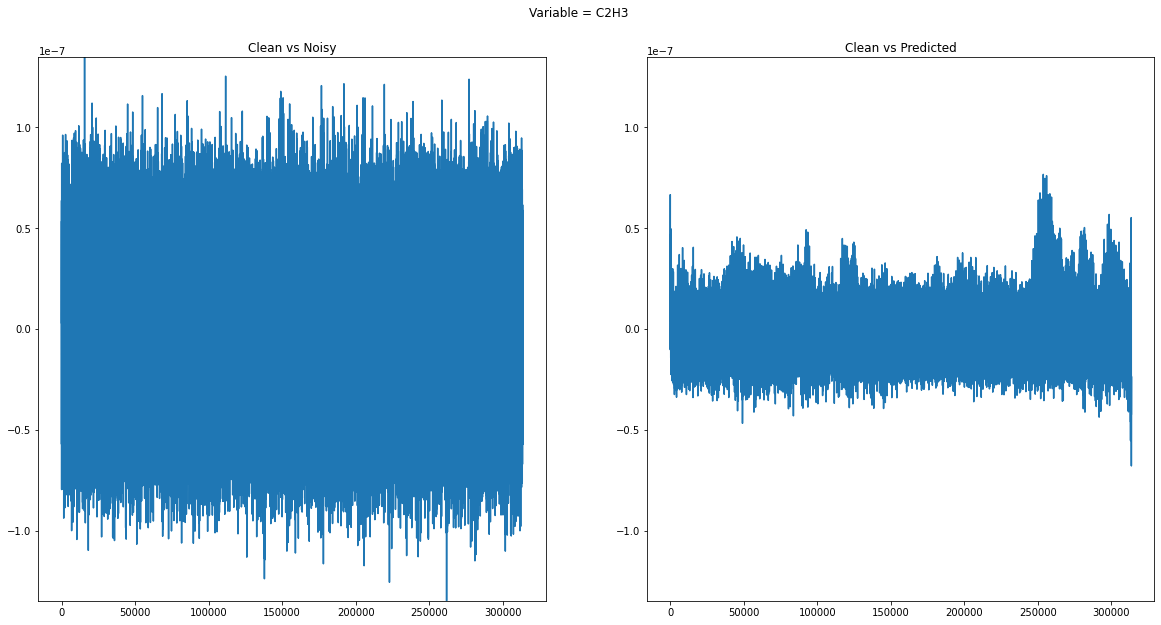

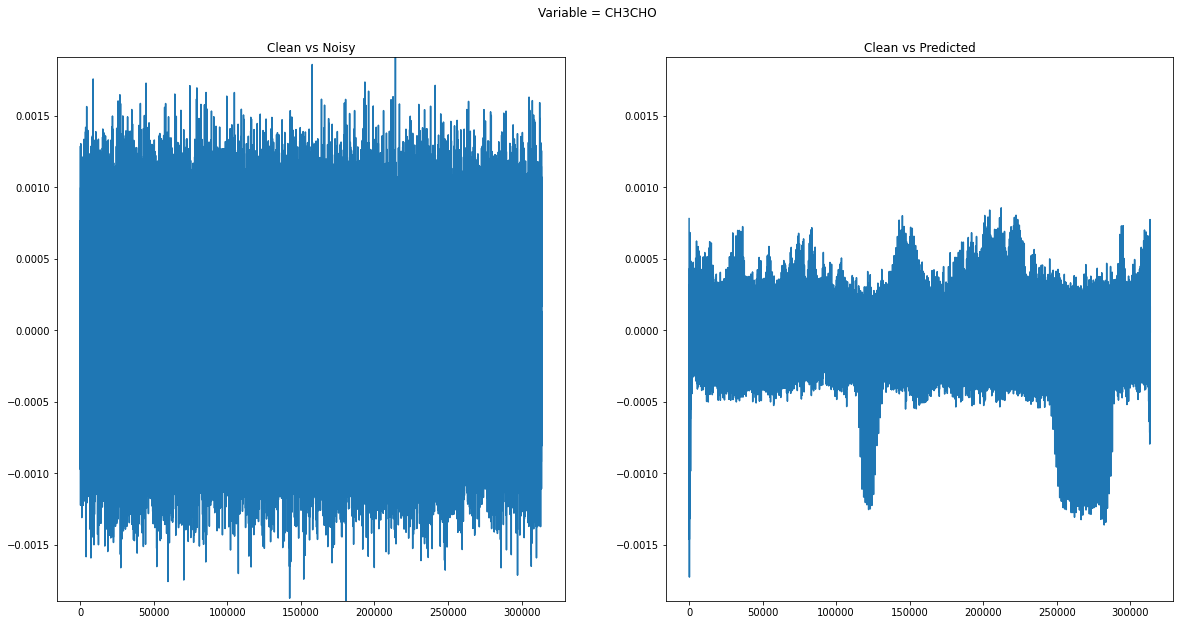

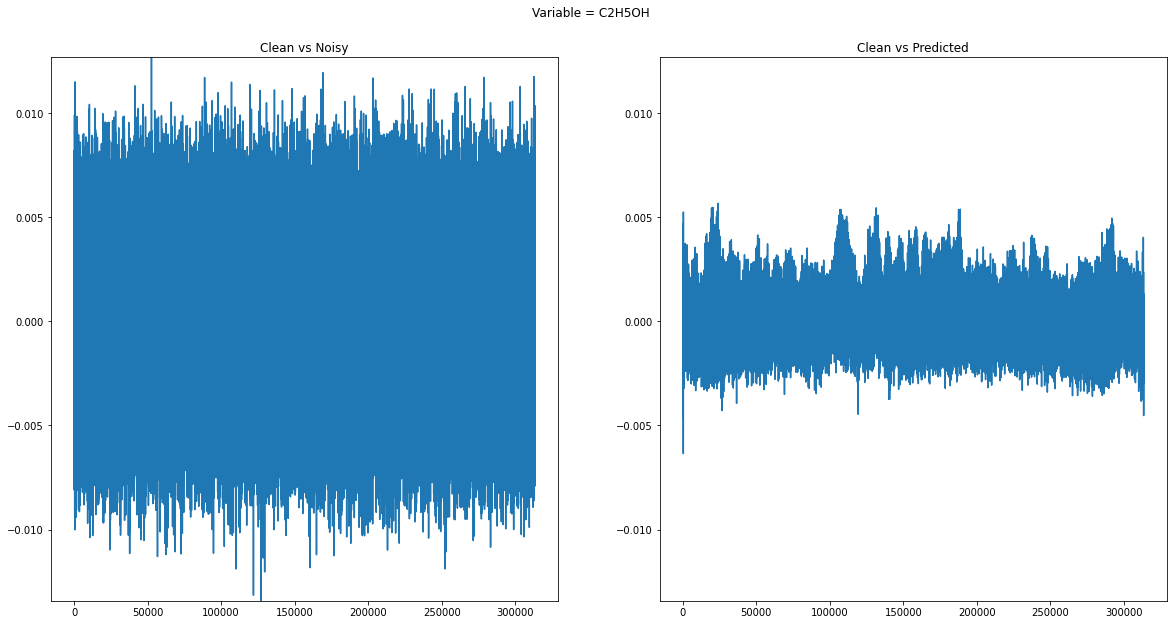

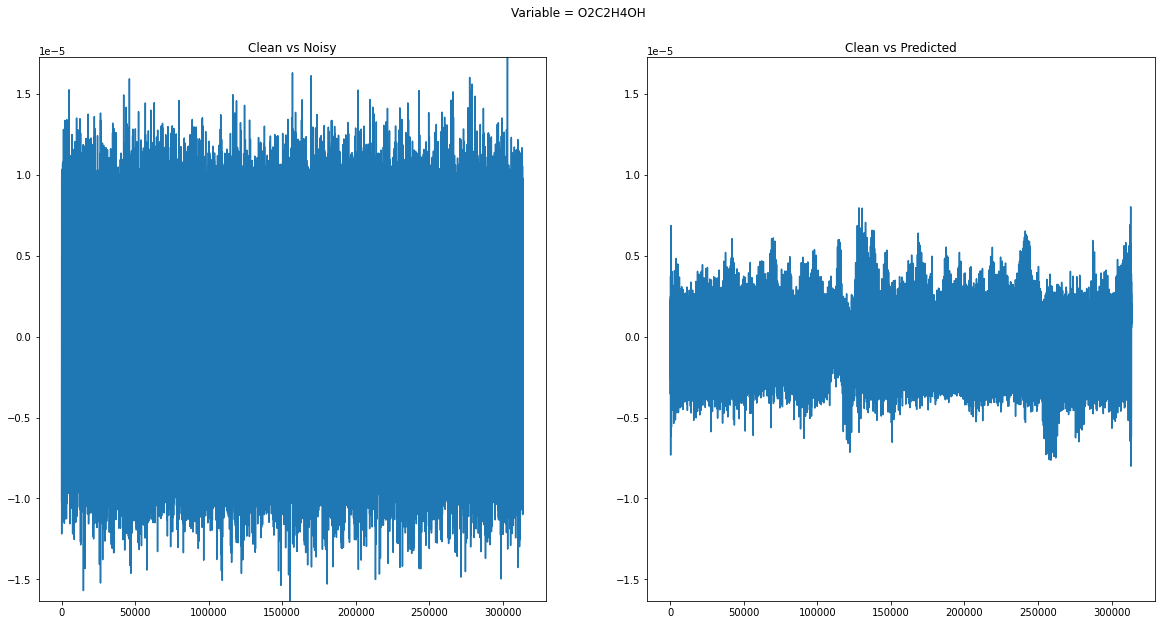

In [ ]:
for j in range(len(variablesIndex)):
  r = np.corrcoef(clean_data[j].flat, predicted[j].flat)[0, 1]
  print(f'Correlation coefficient for {variablesName[j]}: {r}')

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  fig.suptitle(f'Variable = {variablesName[j]}', y=0.95)

  clean_noisy_diff = np.subtract(noisy_data[j].flat, clean_data[j].flat)
  ax1.set_title('Clean vs Noisy')
  ax1.set_ylim([clean_noisy_diff.min(), clean_noisy_diff.max()])
  ax1.plot(clean_noisy_diff)

  clean_pred_diff = np.subtract(predicted[j].flat,clean_data[j].flat)
  ax2.set_title('Clean vs Predicted')
  ax2.set_ylim([clean_noisy_diff.min(), clean_noisy_diff.max()])
  ax2.plot(clean_pred_diff)